In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 13.1MB/s 
     |████████████████████████████████| 901kB 22.9MB/s 
     |████████████████████████████████| 3.3MB 53.0MB/s 


In [4]:
import os, sys

print('Importing dataset...')

from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/Stance Detection")

Importing dataset...
Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./dataset/newTweets.csv")

In [8]:
df.head()

,Party,Tweet
0,Democrat,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RT @Vegalteno: Hurricane season starts on June...


In [12]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(len(df)))

Number of training sentences: 101,267



In [15]:
df["Party"].value_counts()

Republican    44392
Democrat      42068
None          14807
Name: Party, dtype: int64

In [16]:
for i in range(len(df)):
  if df["Party"][i] == 'Democrat':
    df["Party"][i] = int(0)
  elif df["Party"][i] == 'Republican':
    df["Party"][i] = int(1)
  else:
    df["Party"][i] = int(-1)

In [17]:
df["Party"] = df["Party"].astype(str).astype(int)

In [18]:
df["Party"]

0         0
1         0
2         0
3         0
4         0
         ..
101262   -1
101263   -1
101264   -1
101265   -1
101266   -1
Name: Party, Length: 101267, dtype: int64

In [25]:
import re
def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

In [29]:
df['Tweet']=df['Tweet'].apply(str)

In [30]:
for i in range(len(df)):
  result = remove_URL(df["Tweet"][i])
  df["Tweet"][i] = result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# Get the lists of sentences and their labels.
sentences = df.Tweet.values
labels = df.Party.values

In [20]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [33]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the Houseâ¦ 
Tokenized:  ['today', ',', 'senate', 'dem', '##s', 'vote', 'to', '#', 'save', '##the', '##int', '##ern', '##et', '.', 'proud', 'to', 'support', 'similar', '#', 'net', '##ne', '##ut', '##ral', '##ity', 'legislation', 'here', 'in', 'the', 'house', '##a', '##¦']
Token IDs:  [2651, 1010, 4001, 17183, 2015, 3789, 2000, 1001, 3828, 10760, 18447, 11795, 3388, 1012, 7098, 2000, 2490, 2714, 1001, 5658, 2638, 4904, 7941, 3012, 6094, 2182, 1999, 1996, 2160, 2050, 29649]


## Training

In [34]:
input_ids = []
attention_masks = []

# For every sentence
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the Houseâ¦ 
Token IDs: tensor([  101,  2651,  1010,  4001, 17183,  2015,  3789,  2000,  1001,  3828,
        10760, 18447, 11795,  3388,  1012,  7098,  2000,  2490,  2714,  1001,
         5658,  2638,  4904,  7941,  3012,  6094,  2182,  1999,  1996,  2160,
         2050, 29649,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [35]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)


train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} testing samples'.format(test_size))

91,140 training samples
10,127 testing samples


In [36]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

testing_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), 
            batch_size = batch_size 
        )

In [37]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 12-layer BERT model, with an uncased vocab.
    num_labels = 3, 
                    
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [38]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [39]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [40]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [41]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [42]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [44]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_mask = b_input_mask.type(torch.LongTensor)
        b_labels = b_labels.type(torch.LongTensor)

        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    attention_masks
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Testing...")

    t0 = time.time()

    model.eval()

    total_test_accuracy = 0
    total_test_loss = 0
    nb_test_steps = 0

    for batch in testing_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_test_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_test_accuracy += flat_accuracy(logits, label_ids)
        

    avg_test_accuracy = total_test_accuracy / len(testing_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

    avg_test_loss = total_test_loss / len(testing_dataloader)
    
    testing_time = format_time(time.time() - t0)
    
    print("  Testing Loss: {0:.2f}".format(avg_test_loss))
    print("  Testing took: {:}".format(testing_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test. Loss': avg_test_loss,
            'Test. Accur.': avg_test_accuracy,
            'Training Time': training_time,
            'Testing Time': testing_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


RuntimeError: ignored

In [ ]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Test. Loss,Test. Accur.,Training Time,Testing Time
epoch,,,,,
1,0.20,0.54,0.82,0:05:16,0:00:10
2,0.24,0.42,0.83,0:05:16,0:00:10
3,0.16,0.51,0.84,0:05:16,0:00:10
4,0.13,0.51,0.84,0:05:16,0:00:10


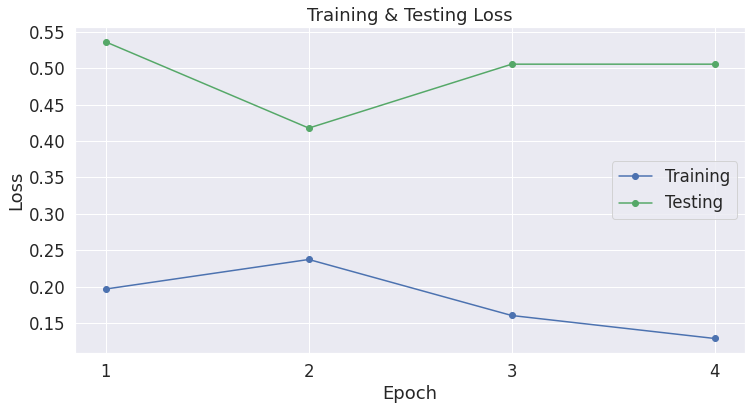

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Test. Loss'], 'g-o', label="Testing")

# Label the plot.
plt.title("Training & Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import os

output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
from transformers import BertForSequenceClassification

output_dir = './saved_model/BERT_model'

print(output_dir)

./saved_model/BERT_model


## Test

In [ ]:
df_test = pd.read_csv("./test.rand.txt", delimiter='\n', header=None, encoding='ISO-8859-1')
df_test.head()

In [ ]:
len(df_test)

In [ ]:
label_lst = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = model.to(device)

for i in range(len(df_test)):
  item = df_test[0][i].split('\t')
  sent1 = item[0]
  sent2 = item[1]

  encoded_dict1 = tokenizer.encode_plus(
                        sent1,                      
                        add_special_tokens = True, 
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )   
  input_id1 = encoded_dict1['input_ids']   
  attention_mask1 = encoded_dict1['attention_mask']
  input_id1 = torch.LongTensor(input_id1)
  attention_mask1 = torch.LongTensor(attention_mask1)

  encoded_dict2 = tokenizer.encode_plus(
                        sent2,                      
                        add_special_tokens = True, 
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )
  input_id2 = encoded_dict2['input_ids']   
  attention_mask2 = encoded_dict2['attention_mask']
  input_id2 = torch.LongTensor(input_id2)
  attention_mask2 = torch.LongTensor(attention_mask2)

  input_id1 = input_id1.to(device)
  attention_mask1 = attention_mask1.to(device)

  input_id2 = input_id2.to(device)
  attention_mask2 = attention_mask2.to(device)

  with torch.no_grad():
    outputs1 = model_loaded(input_id1, token_type_ids=None, attention_mask=attention_mask1)
  with torch.no_grad():
    outputs2 = model_loaded(input_id2, token_type_ids=None, attention_mask=attention_mask2)

  logits1 = outputs1[0]
  logits2 = outputs2[0]
  logits = logits1 / logits2
  index = logits.argmax()
  label_lst.append(index)
  if (i % 1000 == 0):
    print(f'{i} ==> {index}')

In [ ]:
result_lst = []
for i in range(len(label_lst)):
  if label_lst[i] == 1:
    result_lst.append('A')
  else:
    result_lst.append('B')

In [ ]:
with open("./part1_version2.txt", "w") as text_file:
    text_file.write("\n".join(result_lst))